# Exercise 11.2
**Skylar Peven**

**DSC 530**

**02/22/2025**

**13.1**
In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [36]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

# Downloads the python files neccasary for this exercise.
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")

# Downloads data files neccasary for this exercise.
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")

# Download data files of survival cohorts by decade.
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz")

In [37]:
import thinkstats2
import thinkplot
import numpy as np
import pandas as pd
import empiricaldist
import nsfg
import survival

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [38]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp["cmdivorcx"] = resp.cmdivorcx.replace([9998, 9999], np.nan)
    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [42]:
def ResampleDivorceCurve(resps):
    """Plots divorce curves based on resampled data.

    resps: list of respondent DataFrames
    """
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.1)

    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])


def ResampleDivorceCurveByDecade(resps):
    """Plots divorce curves for each birth cohort.

    resps: list of respondent DataFrames
    """
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 28, 0, 1])

def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)    

def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [ ]:
# Survival 
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

# Clean the respondent data.
CleanData(resp6)

# Only selects respondents who have been married.
married6 = resp6[resp6.evrmarry == 1]

# Clean the respondent data.
CleanData(resp7)

# Only selects respondents who have been married.
married7 = resp7[resp7.evrmarry == 1]

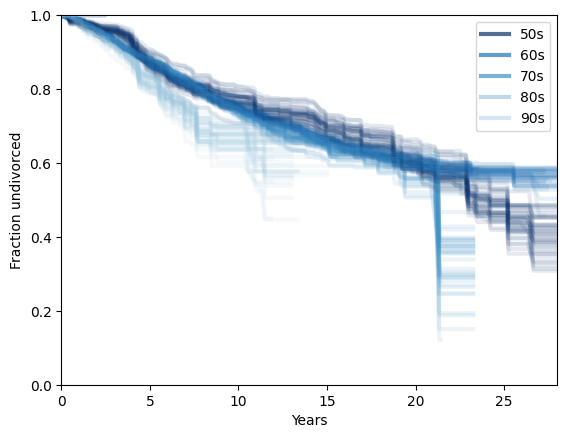

In [47]:
# Visualization of sampling error for  the duration of marriages ending in divorce, grouped by decade.
ResampleDivorceCurveByDecade([married6, married7])